<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marco-canas/arima/blob/main/1_programa_trabajo/2_ejecucion_plan_trabajo/1_dataset_artificial_para_aprendizaje/generacion_datos_artificiales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/marco-canas/arima/blob/main/1_programa_trabajo/2_ejecucion_plan_trabajo/1_dataset_artificial_para_aprendizaje/generacion_datos_artificiales.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Prompt para el diseño de la metodología de consolidación de datos meteorológicos y epidemiológicos: 

Emulando a un experto en análisis de series temporales y modelado estadístico, especializado en la consolidación de datos meteorológicos y epidemiológicos. Dame el script de Python para generar datos meteorológicos para Caucasia Antioquia (Colombia) para ser modelados con SARIMAX, asegurando su calidad y relevancia para futuros análisis. Pero los datos deben ser del intervalo de tiempo de primero de enero de 2021 a 31 de diciembre de 2025:   


1. **Recolección de Datos**: Describe cómo y dónde se obtendrán los datos meteorológicos de la siguiente lista: 
    1. De la fuente Antioquia Mira Su Cielo (AMSC) donde la frecuencia de los datos es por minuto y los tributos que me brinda son:  
       * Temperatura máxima diaria (°C)
       * Temperatura mínima diaria (°C)
       * Temperatura media diaria (°C)
       * Humedad relativa media diaria (%)
       * Humedad específica diaria (kg/kg o g/kg)
       * Velocidad del viento media diaria (m/s)
       * Velocidad del viento máxima diaria (m/s)
       * Velocidad del viento mínima diaria (m/s)
       * Precipitación diaria (mm)
       * Días con lluvia por semana epidemiológica
       * Radiación ultravioleta diaria (UV index)
       * Presión atmosférica media diaria (hPa)

    
     
    2. Recolección del datos meteorológicos de la fuente: NASA Power, donde la frecuencia es diaria y los atributos que me brinda son:  
        * Temperatura máxima diaria (°C)
        * Temperatura mínima diaria (°C)
        * Temperatura media diaria (°C)
        * Humedad relativa media diaria (%)
        * Humedad específica diaria (kg/kg o g/kg)
        * Velocidad del viento media diaria (m/s)
        * Velocidad del viento máxima diaria (m/s)
        * Velocidad del viento mínima diaria (m/s)
        * Precipitación diaria (mm)
        * Días con lluvia por semana epidemiológica
        * Radiación ultravioleta diaria (UV index)
        * Presión atmosférica media diaria (hPa)



# Metodología breve (dónde y cómo se obtienen los datos)



**AMSC (Antioquia Mira Su Cielo)**

* Dónde: visor/portal AMSC (lista de estaciones / Metvisor). Si AMSC ofrece exportación CSV/JSON por estación, solicita o descarga allí; si no está disponible públicamente, coordina con el equipo AMSC para extracción.
* Cómo: idealmente consigue archivos crudos por estación a frecuencia *por minuto*. El script abajo asume que dispones de CSVs por estación con una columna `datetime` (hora local America/Bogota) y columnas de sensor (T, RH, ws, precip, specific_humidity, pressure, uv_index, etc.). Si no existe API pública, exporta manualmente/solicita extracción y coloca los archivos en una carpeta `data/AMSC_minute/`.

**NASA POWER**

* Dónde: API pública Daily de NASA POWER (solicitudes por coordenadas, formato CSV/JSON).
* Cómo: usa la API `https://power.larc.nasa.gov/api/temporal/daily/point` solicitando los parámetros deseados para las coordenadas de Caucasia. El script incluye una función que descarga la serie diaria entre 2021-01-01 y 2025-12-31 y la guarda en `data/nasa_power_caucasia.csv`.

---

# Script Python completo

Guarda como `build_meteorological_dataset_caucasia.py`. Requiere: `pandas`, `numpy`, `requests`, `pyproj` (opcional), `pytz`.
Explicación: descarga NASA POWER, lee archivos AMSC minuto (esperados en folder), aplica QA, resamplea minuto→día, armoniza variables, calcula semanas epidemiológicas (si entregas calendario INS lo usa; si no, usa ISO-week como fallback) y genera dataset diario y semanal listo para SARIMAX (con lags y features).

```python


In [7]:
#!/usr/bin/env python3
"""
build_meteorological_dataset_caucasia.py

Genera datos meteorológicos diarios y semanales (2021-01-01 .. 2025-12-31)
a partir de:
 - AMSC (datos minuto -> local CSVs en folder data/AMSC_minute/)
 - NASA POWER (descarga por API)

Salida:
 - data/processed/daily_meteo.parquet
 - data/processed/weekly_meteo.parquet

NOTAS:
 - AMSC: el script asume que tienes CSVs por estación con columnas (datetime (local), t_c, rh, spfh, ws, ws_max, ws_min, precip_mm, uv_index, pressure_hpa)
 - Si el calendario de semanas epidemiológicas (INS) está disponible, pásalo a `epi_calendar_path` para mapear correctamente a SE. Si no, el script usa ISO-week como fallback (advertencia).
"""
import os
import glob
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import requests
import pytz

# --- Configuración principal ---
LATITUDE = 7.9890    # aproximado Caucasia
LONGITUDE = -75.1956
START_DATE = "2021-01-01"
END_DATE = "2025-12-31"
OUTPUT_DIR = "data/processed"
AMSC_MINUTE_FOLDER = "data/AMSC_minute"   # colocar aquí los CSVs minuto de AMSC
EPI_CALENDAR_PATH = None  # si tienes un CSV mapping date->epi_week, pon la ruta aquí

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs("data", exist_ok=True)


In [8]:

# -----------------------------
# Helper: Descargar NASA POWER
# -----------------------------
def download_nasa_power(lat, lon, start, end, out_csv="data/nasa_power_caucasia.csv",
                        parameters=None):
    """
    Descarga la API Daily de NASA POWER para lat/lon y guarda CSV.
    """
    if parameters is None:
        # parámetros sugeridos (ajusta nombres según catálogo POWER)
        parameters = ",".join([
            "T2M",       # temp media diaria (°C)
            "T2M_MAX",   # Tmax
            "T2M_MIN",   # Tmin
            "SPFH",      # specific humidity (kg/kg)
            "RH2M",      # relative humidity (may not be available directly; POWER has RH deriv.)
            "WS10M",     # wind speed
            "PRECTOT",   # precip total (mm/day)
            "PS",        # pressure surface (Pa or hPa, check output)
            "ALLSKY_SFC_UV_INDEX"  # UV index
        ])
    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "start": start.replace("-", ""),
        "end": end.replace("-", ""),
        "latitude": str(lat),
        "longitude": str(lon),
        "parameters": parameters,
        "format": "CSV",
        "user": "anonymous"
    }
    print(f"Descargando NASA POWER: {start} -> {end} para {lat},{lon} ...")
    r = requests.get(url, params=params, timeout=60)
    if r.status_code != 200:
        raise RuntimeError(f"Error descargando NASA POWER: {r.status_code} {r.text[:200]}")
    with open(out_csv, "wb") as f:
        f.write(r.content)
    print("Guardado NASA POWER en", out_csv)
    # leer y devolver df
    df = pd.read_csv(out_csv, comment='#')
    # El csv tiene una columna 'YYYYMMDD' o 'DATE'; intentar parseo flexible
    if 'YYYYMMDD' in df.columns:
        df['date'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
    elif 'DATE' in df.columns:
        df['date'] = pd.to_datetime(df['DATE'])
    else:
        # intentar primera columna parse
        df['date'] = pd.to_datetime(df.iloc[:,0])
    df = df.set_index('date').sort_index()
    return df


In [11]:

# ------------------------------------------------
# Helper: Leer AMSC minuto (asume múltiples CSVs)
# ------------------------------------------------
def read_amsc_minute_folder(folder=AMSC_MINUTE_FOLDER, tzname="America/Bogota"):
    """
    Lee todos los CSVs en `folder` y concatena.
    Se espera que cada CSV tenga:
      - 'datetime' (string ISO local) OR index as datetime
      - columnas: t_c, rh_pct, spfh (kg/kg), ws (m/s), ws_max, ws_min, precip_mm, uv_index, pressure_hpa
    Normaliza nombres de columnas si es necesario.
    """
    files = glob.glob(os.path.join(folder, "*.csv"))
    if len(files) == 0:
        warnings.warn(f"No se encontraron CSVs en {folder}. Asegúrate de exportar AMSC por estación allí.")
        return pd.DataFrame()
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # intenta detectar datetime column
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df = df.set_index('datetime')
        else:
            # intentar la primera columna
            try:
                df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
                df = df.set_index(df.columns[0])
            except Exception:
                raise RuntimeError(f"No pude detectar columna datetime en {f}")
        # localizar tz
        df.index = df.index.tz_localize(pytz.timezone(tzname), ambiguous='infer', nonexistent='shift_forward')
        # normalizar nombres más comunes
        df = df.rename(columns={
            't_c':'temp_c', 'temperature_c':'temp_c', 'temp':'temp_c',
            'rh':'rh_pct','rh_%':'rh_pct','relative_humidity':'rh_pct',
            'spfh':'spfh','specific_humidity':'spfh',
            'ws':'ws_mean','wind_speed':'ws_mean',
            'ws_max':'ws_max','ws_min':'ws_min',
            'precip':'precip_mm','precip_mm':'precip_mm','rain_mm':'precip_mm',
            'uv_index':'uv_index','pressure_hpa':'pressure_hpa','pressure':'pressure_hpa'
        })
        dfs.append(df)
    df_all = pd.concat(dfs, axis=0).sort_index()
    # Si hay duplicados por timestamp, tomar promedio
    df_all = df_all[~df_all.index.duplicated(keep='first')]
    print(f"Leídos {len(files)} archivos AMSC, total registros: {len(df_all)}")
    return df_all


In [13]:

# ------------------------------------------------
# QC / Aggregation minute -> daily
# ------------------------------------------------
def minute_to_daily(df_minute):
    """
    Resample minute -> daily with these rules:
     - Tmax = max(temp)
     - Tmin = min(temp)
     - Tmean = mean(temp)
     - precip_daily = sum(precip_mm)
     - ws_mean, ws_max, ws_min accordingly
     - specific humidity and pressure => daily mean
     - uv_index -> daily_max (o daily_mean según preferencia)
    También añade flags de calidad: pct_missing_minute_per_day, low_quality_day (True si >30% missing)
    """
    if df_minute.empty:
        return pd.DataFrame()
    # normalizar nombres esperados
    cols = df_minute.columns
    # resampling
    agg_dict = {}
    if 'temp_c' in cols:
        agg_dict.update({'temp_c':'mean', 'temp_c':'mean'})  # mean used for temp; we'll compute min/max separately below
    # compute separately
    daily = pd.DataFrame()
    if 'temp_c' in cols:
        daily['tmean_c'] = df_minute['temp_c'].resample('D').mean()
        daily['tmax_c'] = df_minute['temp_c'].resample('D').max()
        daily['tmin_c'] = df_minute['temp_c'].resample('D').min()
    if 'precip_mm' in cols:
        daily['precip_mm'] = df_minute['precip_mm'].resample('D').sum(min_count=1).fillna(0.0)
    if 'ws_mean' in cols:
        daily['ws_mean'] = df_minute['ws_mean'].resample('D').mean()
    if 'ws_max' in cols:
        daily['ws_max'] = df_minute['ws_max'].resample('D').max()
    if 'ws_min' in cols:
        daily['ws_min'] = df_minute['ws_min'].resample('D').min()
    if 'spfh' in cols:
        daily['spfh_kgkg'] = df_minute['spfh'].resample('D').mean()
    if 'rh_pct' in cols:
        daily['rh_pct'] = df_minute['rh_pct'].resample('D').mean()
    if 'pressure_hpa' in cols:
        daily['pressure_hpa'] = df_minute['pressure_hpa'].resample('D').mean()
    if 'uv_index' in cols:
        daily['uv_index_max'] = df_minute['uv_index'].resample('D').max()
        daily['uv_index_mean'] = df_minute['uv_index'].resample('D').mean()

    # quality flags: percent missing per day relative to expected minutes (1440)
    # If different sampling rate, better compute expected per day from mode of per-day counts
    counts = df_minute.resample('D').size()
    expected = counts.mode().iloc[0] if not counts.empty else 1440
    pct_missing = (1 - counts / expected).clip(0,1)
    daily['pct_missing_minute'] = pct_missing
    daily['low_quality_day'] = daily['pct_missing_minute'] > 0.30

    daily.index = daily.index.tz_convert(None)  # drop tz for simpler merges (use local dates)
    return daily


In [14]:

# ------------------------------------------------
# Simple QA checks
# ------------------------------------------------
def apply_basic_qc(df_daily):
    """
    Aplica checks de rango físico y marca outliers simples.
    Agrega columnas *_qc_flag con:
      0 ok, 1 suspect/out-of-range, 2 missing
    """
    if df_daily.empty:
        return df_daily
    df = df_daily.copy()
    # ranges
    ranges = {
        'tmean_c': (-30, 50),
        'tmax_c': (-30, 60),
        'tmin_c': (-50, 50),
        'rh_pct': (0, 100),
        'spfh_kgkg': (0, 0.03),  # approx for tropics; adjust if needed (kg/kg)
        'ws_mean': (0, 60),
        'ws_max': (0, 80),
        'precip_mm': (0, 1000),
        'pressure_hpa': (800, 1100),
        'uv_index_max': (0, 20)
    }
    for col, (lo, hi) in ranges.items():
        if col in df.columns:
            flag_col = col + "_qc_flag"
            df[flag_col] = 0
            df.loc[df[col].isna(), flag_col] = 2
            df.loc[(df[col] < lo) | (df[col] > hi), flag_col] = 1
    # outlier detection: rolling zscore (7-day)
    for col in ['tmean_c','precip_mm','ws_mean']:
        if col in df.columns:
            roll_mean = df[col].rolling(7, min_periods=3, center=True).mean()
            roll_std = df[col].rolling(7, min_periods=3, center=True).std().replace(0, np.nan)
            z = ((df[col] - roll_mean) / roll_std).abs()
            outlier_flag_col = col + "_outlier_flag"
            df[outlier_flag_col] = (z > 4).astype(int)  # 1 si outlier
    return df


In [ ]:

# ------------------------------------------------
# Map to epidemiological week (INS) or fallback ISO-week
# ------------------------------------------------
def map_to_epiweek(daily_df, epi_calendar_path=None):
    """
    Devuelve dataframe weekly aggregated by epi-week:
      - if epi_calendar_path CSV provided: expect columns date (YYYY-MM-DD) and epi_week (e.g., '2021-W01' or integer)
      - otherwise: use ISO week (pandas .isocalendar())
    weekly aggregation: sum precip, mean temps, count days_with_rain (precip >= 1 mm)
    """
    df = daily_df.copy()
    df = df.sort_index()
    df['date'] = df.index
    if epi_calendar_path and os.path.exists(epi_calendar_path):
        cal = pd.read_csv(epi_calendar_path, parse_dates=['date'])
        cal = cal.set_index('date')
        # join
        df = df.join(cal, how='left')
        if 'epi_week' not in df.columns:
            raise RuntimeError("epi_calendar must have column 'epi_week'")
        # group by epi_week
        group = df.groupby('epi_week')
        weekly = group.agg({
            'precip_mm':'sum',
            'tmean_c':'mean',
            'tmax_c':'max',
            'tmin_c':'min',
            'ws_mean':'mean',
            'pressure_hpa':'mean',
            'spfh_kgkg':'mean',
            'rh_pct':'mean',
            'uv_index_max':'max',
            'pct_missing_minute':'mean'
        }).rename(columns={'precip_mm':'week_precip_mm'})
        # days with rain
        days_with_rain = group.apply(lambda g: (g['precip_mm']>=1.0).sum()).rename('days_with_rain')
        weekly = weekly.join(days_with_rain)
        weekly.index.name = 'epi_week'
        return weekly
    else:
        warnings.warn("No epi calendar provided; usando ISO-week como fallback. Para coherencia con INS, provee calendario INS.")
        isocal = df['date'].dt.isocalendar()
        df['year_week'] = isocal['year'].astype(str) + "-W" + isocal['week'].astype(str).str.zfill(2)
        group = df.groupby('year_week')
        weekly = group.agg({
            'precip_mm':'sum',
            'tmean_c':'mean',
            'tmax_c':'max',
            'tmin_c':'min',
            'ws_mean':'mean',
            'pressure_hpa':'mean',
            'spfh_kgkg':'mean',
            'rh_pct':'mean',
            'uv_index_max':'max',
            'pct_missing_minute':'mean'
        }).rename(columns={'precip_mm':'week_precip_mm'})
        days_with_rain = group.apply(lambda g: (g['precip_mm']>=1.0).sum()).rename('days_with_rain')
        weekly = weekly.join(days_with_rain)
        weekly.index.name='year_week'
        return weekly


In [ ]:

# ------------------------------------------------
# Merge NASA daily + AMSC daily and compute biases
# ------------------------------------------------
def merge_nasa_amsc(nasa_df_raw, amsc_daily):
    """
    Recibe df raw de NASA (index date) y amsc_daily (index date). Normaliza nombres y combina.
    Devuelve merged df con columnas suffixes _nasa and _amsc si ambos existen, y columnas bias (amsc - nasa).
    """
    if nasa_df_raw is None or nasa_df_raw.empty:
        return amsc_daily.copy()
    # map NASA column names to expected
    df_nasa = nasa_df_raw.copy()
    # intentar detectar columnas comunes
    # heurística: columnas con 'T2M' => temp mean, 'T2M_MAX' => tmax, 'PRECTOT' => precip, 'ALLSKY_SFC_UV_INDEX' or similar
    col_map = {}
    for c in df_nasa.columns:
        uc = c.upper()
        if 'T2M_MAX' in uc or 'T2M_MAX' == uc:
            col_map[c] = 'tmax_c_nasa'
        elif 'T2M_MIN' in uc:
            col_map[c] = 'tmin_c_nasa'
        elif uc == 'T2M' or 'T2M' in uc:
            col_map[c] = 'tmean_c_nasa'
        elif 'PRECTOT' in uc or 'PRCP' in uc or 'PRECIP' in uc:
            col_map[c] = 'precip_mm_nasa'
        elif 'SPFH' in uc:
            col_map[c] = 'spfh_kgkg_nasa'
        elif 'WS10M' in uc or 'WS' in uc:
            col_map[c] = 'ws_mean_nasa'
        elif 'PS' in uc:
            col_map[c] = 'pressure_hpa_nasa'  # careful: units might be Pa
        elif 'UV' in uc:
            col_map[c] = 'uv_index_nasa'
        elif 'RH' in uc:
            col_map[c] = 'rh_pct_nasa'
    df_nasa = df_nasa.rename(columns=col_map)
    # ensure index is datetime
    if not isinstance(df_nasa.index, pd.DatetimeIndex):
        if 'date' in df_nasa.columns:
            df_nasa = df_nasa.set_index(pd.to_datetime(df_nasa['date']))
        else:
            df_nasa.index = pd.to_datetime(df_nasa.index)
    # convert units: if pressure in Pa convert to hPa
    if 'pressure_hpa_nasa' in df_nasa.columns:
        # heuristic: if values > 2000 assume Pa
        if df_nasa['pressure_hpa_nasa'].dropna().gt(2000).any():
            df_nasa['pressure_hpa_nasa'] = df_nasa['pressure_hpa_nasa'] / 100.0

    # align daily index to no tz
    df_nasa.index = df_nasa.index.tz_convert(None) if df_nasa.index.tz is not None else df_nasa.index
    amsc = amsc_daily.copy()
    merged = amsc.join(df_nasa, how='outer')
    # compute biases where both present
    for var in ['tmean_c','tmax_c','tmin_c','precip_mm','ws_mean','pressure_hpa','spfh_kgkg','rh_pct','uv_index_max']:
        nasa_var = f"{var}_nasa" if var != 'uv_index_max' else 'uv_index_nasa'
        amsc_var = var
        if amsc_var in merged.columns and nasa_var in merged.columns:
            merged[f"bias_{amsc_var}"] = merged[amsc_var] - merged[nasa_var]
    return merged


In [ ]:

# ------------------------------------------------
# Create exogenous features: lags and rolling windows
# ------------------------------------------------
def create_features_for_sarimax(df, target_col=None, lags_weeks=(1,2,3,4,8,12)):
    """
    Asume df index diario o weekly. Si index es diario y lags_weeks specified,
    convert lags to days (7*weeks).
    Devuelve df con columnas de lag de precip y temp y rolling means.
    """
    out = df.copy()
    is_daily = (out.index.freq is None) or (pd.infer_freq(out.index) in ['D','H','T',None])
    for w in lags_weeks:
        lag_days = 7*w
        # create lag for weekly aggregated variables but we'll do generic shifting
        if 'week_precip_mm' in out.columns:
            out[f'precip_lag_{w}w'] = out['week_precip_mm'].shift(w)
            out[f'precip_roll_{w}w_sum'] = out['week_precip_mm'].rolling(window=w, min_periods=1).sum()
        if 'precip_mm' in out.columns and is_daily:
            out[f'precip_lag_{w}w'] = out['precip_mm'].shift(lag_days)
            out[f'precip_roll_{w}w_sum'] = out['precip_mm'].rolling(window=lag_days, min_periods=1).sum()
        if 'tmean_c' in out.columns:
            out[f'tmean_lag_{w}w'] = out['tmean_c'].shift(w*7 if is_daily else w)
            out[f'tmean_roll_{w}w_mean'] = out['tmean_c'].rolling(window=w*7 if is_daily else w, min_periods=1).mean()
    # standardize numeric exogenous (store scaler externally in production)
    return out


Descargando NASA POWER: 2021-01-01 -> 2025-12-31 para 7.989,-75.1956 ...
Error descargando NASA POWER: Error descargando NASA POWER: 422 {"detail":[{"type":"missing","loc":["query","community"],"msg":"Field required","input":null}]}


C:\Users\marco\AppData\Local\Temp\ipykernel_9708\1428032033.py:103: UserWarning: No se encontraron CSVs en data/AMSC_minute. Asegúrate de exportar AMSC por estación allí.
  warnings.warn(f"No se encontraron CSVs en {folder}. Asegúrate de exportar AMSC por estación allí.")


NameError: name 'minute_to_daily' is not defined

In [9]:

# ------------------------------------------------
# Main pipeline
# ------------------------------------------------
def main():
    # 1) descargar NASA POWER
    try:
        nasa_raw = download_nasa_power(LATITUDE, LONGITUDE, START_DATE, END_DATE,
                                       out_csv="data/nasa_power_caucasia.csv")
    except Exception as e:
        print("Error descargando NASA POWER:", e)
        nasa_raw = pd.DataFrame()

    # 2) leer AMSC minuto (local CSVs)
    amsc_minute = read_amsc_minute_folder(AMSC_MINUTE_FOLDER)
    amsc_daily = minute_to_daily(amsc_minute)
    print(f"AMSC daily records: {len(amsc_daily)}")

    # 3) aplicar QC basico
    amsc_daily_qc = apply_basic_qc(amsc_daily)

    # 4) merge NASA and AMSC (daily)
    merged = merge_nasa_amsc(nasa_raw, amsc_daily_qc)

    # 5) create daily dataset canonical: fill missing from NASA where AMSC missing (policy configurable)
    # Example policy: prefer AMSC (in-situ) when available, else use NASA
    daily = pd.DataFrame(index=pd.date_range(START_DATE, END_DATE, freq='D'))
    for var in ['tmean_c','tmax_c','tmin_c','precip_mm','ws_mean','ws_max','ws_min','spfh_kgkg','rh_pct','pressure_hpa','uv_index_max']:
        col_amsc = var
        col_nasa = f"{var}_nasa" if var != 'uv_index_max' else 'uv_index_nasa'
        if col_amsc in merged.columns and col_nasa in merged.columns:
            daily[var] = merged[col_amsc].combine_first(merged[col_nasa])
        elif col_amsc in merged.columns:
            daily[var] = merged[col_amsc]
        elif col_nasa in merged.columns:
            daily[var] = merged[col_nasa]
    # also bring quality flags
    if 'pct_missing_minute' in merged.columns:
        daily['pct_missing_minute'] = merged['pct_missing_minute']
    # 6) final QC on daily
    daily = apply_basic_qc(daily)

    # 7) weekly aggregation by epi-week (or ISO-week fallback)
    weekly = map_to_epiweek(daily, epi_calendar_path=EPI_CALENDAR_PATH)

    # 8) create exogenous features
    weekly_feat = create_features_for_sarimax(weekly)

    # 9) export
    daily.to_parquet(os.path.join(OUTPUT_DIR, "daily_meteo.parquet"))
    weekly_feat.to_parquet(os.path.join(OUTPUT_DIR, "weekly_meteo.parquet"))
    print("Exportados:")
    print("-", os.path.join(OUTPUT_DIR, "daily_meteo.parquet"))
    print("-", os.path.join(OUTPUT_DIR, "weekly_meteo.parquet"))
    # 10) resumen simple
    print("\nResumen diario (head):")
    print(daily.head())
    print("\nResumen semanal (head):")
    print(weekly_feat.head())

if __name__ == "__main__":
    main()


Descargando NASA POWER: 2021-01-01 -> 2025-12-31 para 7.989,-75.1956 ...
Error descargando NASA POWER: Error descargando NASA POWER: 422 {"detail":[{"type":"missing","loc":["query","community"],"msg":"Field required","input":null}]}


C:\Users\marco\AppData\Local\Temp\ipykernel_9708\1428032033.py:103: UserWarning: No se encontraron CSVs en data/AMSC_minute. Asegúrate de exportar AMSC por estación allí.
  warnings.warn(f"No se encontraron CSVs en {folder}. Asegúrate de exportar AMSC por estación allí.")


NameError: name 'minute_to_daily' is not defined

```

---

# Notas importantes y recomendaciones prácticas

1. **AMSC: formato y acceso** — el script *no* ejecuta scraping en el portal AMSC. Lo recomendable es pedir los archivos crudos (CSV/JSON) por estación o solicitar una exportación masiva al equipo AMSC. Luego coloca esos CSV en `data/AMSC_minute/` con nombres legibles (p.ej. `amsc_caucasia_station01_2021_2025.csv`).

2. **NASA POWER** — la API puede cambiar nombres concretos de parámetros; revisa el catálogo de parámetros en la documentación POWER y ajusta `parameters` del `download_nasa_power`. En el CSV de POWER algunos campos vienen en Pa (no hPa), o nombres distintos; el script usa heurísticas para renombrar. Verifica manualmente la salida `data/nasa_power_caucasia.csv`.

3. **Semana epidemiológica (INS)** — para coherencia con SIVIGILA utiliza el *calendario oficial del INS*. Si lo cargas en `EPI_CALENDAR_PATH` (CSV con fecha->epi_week) el script agrupará por esa SE; si no lo haces, el script usa ISO-week como *fallback* (advertencia que puede diferir del INS). Es preferible proveer el calendario INS.

4. **Calidad y trazabilidad** — el flujo marca `pct_missing_minute` y `low_quality_day` y agrega banderas QC. En producción registra también `extraction_timestamp`, `source` y `pipeline_version` en metadatos.

5. **Unidades** — valida `spfh` (specific humidity) y presión (Pa vs hPa). El script intenta detectar Pa > 2000 y convertir a hPa.

6. **Imputación** — aquí sólo se hace relleno preferente NASA→AMSC; para huecos largos deberías considerar imputaciones más sofisticadas: regresión con estaciones vecinas, kriging, kalman smoothing, o usar modelos para imputar (documentar método y porcentaje imputado).

7. **SARIMAX** — para SARIMAX, normalmente trabajarás con series *semanales* de casos (target) y exógenas agregadas por SE (ej. `week_precip_mm`, `days_with_rain`, `tmean_lag_1w`, etc.). El script genera `weekly_meteo.parquet` con `days_with_rain` y otros agregados (si provees calendario INS o usa ISO-week).

---

Si quieres, lo siguiente que puedo hacer **ahora mismo** (elige una opción y la ejecuto en este mensaje):

1. **Adaptar/ejecutar el script** y generar un *notebook de ejemplo* que muestre: (a) descarga NASA POWER; (b) ejemplo de AMSC con archivo de muestra que me des; (c) QA y gráficos de comparación (bias).
2. **Generar la plantilla de metadatos** (CSV/README) que documente cada columna, unidad, rangos y flags de QC para tu equipo.
3. **Modificar el script** para que en lugar de esperar CSVs AMSC, intente consultar directamente si me das la URL o la API (si AMSC tiene endpoint), y luego probar una descarga.

Dime cuál prefieres y lo hago ya.


2. Gereración de datos epidemiológicos sobre dengue de la Secretaría de Salud. Donde la frecuencia es diaria. 

3. **Integración de Datos**: Explica cómo se combinarán los datos meteorológicos y epidemiológicos en un solo conjunto de datos. Detalla los métodos para alinear temporalmente los datos, manejar diferentes frecuencias de muestreo y asegurar la coherencia entre las variables.  

 
1. **Limpieza de Datos**: Explica los procedimientos para identificar y manejar datos faltantes, valores atípicos y errores de medición. Detalla las técnicas que se utilizarán para imputar datos faltantes y corregir errores, asegurando la integridad de los conjuntos de datos.  
2. **Transformación de Datos**: Describe cómo se transformarán los datos para facilitar su análisis. Esto puede incluir la normalización, estandarización, creación de variables derivadas (por ejemplo, medias móviles, índices de calor) y la conversión de formatos de fecha y hora.  

4. **Análisis Exploratorio de Datos (EDA)**: Describe las técnicas que se utilizarán para explorar los datos consolidados, identificar patrones, tendencias y relaciones entre las variables meteorológicas y epidemiológicas. Incluye visualizaciones recomendadas y estadísticas descriptivas.  
5. **Documentación y Reproducibilidad**: Explica cómo se documentará cada paso del proceso de consolidación de datos para asegurar la reproducibilidad. Incluye recomendaciones sobre el uso de herramientas de control de versiones y la creación de informes detallados.


# Metodología hasta hoy 21 de Septiembre de 2025  

Esta es una metodología práctica, detallada y reproducible (emulando a un experto en series temporales y modelado SARIMAX) para consolidar datos meteorológicos y epidemiológicos de **Caucasia, Antioquia (Colombia)**, lista para ejecutar y reutilizar por tu equipo de investigación. Incluyo recomendaciones técnicas, criterios de calidad y pasos concretos para cada etapa solicitada.



# Metodología para consolidación de datos meteorológicos y epidemiológicos (orientada a SARIMAX)

---



## 1) Recolección de Datos

**Objetivo**: reunir series temporales completas y bien documentadas de variables meteorológicas y epidemiológicas.

**Fuentes recomendadas (ejemplos prácticos para Caucasia)**

* **Meteorología**: IDEAM (estaciones meteorológicas nacionales), proyectos regionales como *Antioquia — Mira su Cielo*, repositorios académicos o redes agrícolas (p. ej. datos de Fedearroz si disponibles para lluvia/temperatura).
* **Epidemiología**: Secretaría de Salud Municipal de Caucasia (casos notificados, hospitalizaciones), Secretaría Seccional de Salud de Antioquia, INS (boletines nacionales), registros hospitalarios locales (EPS/hospital), SIVIGILA (cuando aplique).
* **Metadatos y geolocalización**: fichas de estación IDEAM (altura, lat/long, cambios de sensor), documentación de protocolos de muestreo epidemiológico (definición de caso, fecha de inicio, fecha de notificación).

**Frecuencia y período recomendado**

* **Frecuencia primaria**: **diaria** (ideal para meteorología y para modelar incidencia con retardo).
* **Agrupaciones**: conservar la granularidad diaria y proporcionar resúmenes semanales/mensuales según necesidad.
* **Período mínimo aconsejado**: **>10 años**; si es posible usar **2020–2025 (≥5 años)** para capturar variabilidad interanual y estacional — esto coincide con trabajos previos en la región y mejora la robustez del SARIMAX.
* **Fecha y zona horaria**: registrar en **ISO 8601** (YYYY-MM-DD) y usar **America/Bogota (UTC-5)** consistentemente.

**Práctica operativa**

* Automatizar descargas (APIs, FTP, scrapers controlados) y almacenar **raw/** sin modificar.
* Registrar el *hash* (SHA256) de cada archivo crudo y la fecha de extracción.
* Mantener un inventario (CSV/JSON) con: fuente, variable, frecuencia, periodo, contacto, licencias.

---


# datos artificiales diarios para **2020-01-01 → 2025-12-31** y produce un paquete "raw" con metadatos e inventario. Abajo te dejo:

1. El **script completo** (para copiar/pegar y ejecutar localmente).
2. Un resumen de lo que genera y los archivos de salida, incluyendo la ruta del ZIP con todos los CSV raw.





# 1) Script (copia — es el mismo que ejecuté aquí)


In [ ]:

# Generación de datos sintéticos para "Recolección de Datos" (Caucasia, Antioquia)
# Crea datos meteorológicos diarios (2 estaciones) y datos epidemiológicos diarios
# (casos y hospitalizaciones a nivel municipal) para 2020-01-01 a 2025-12-31.
# Guarda archivos en ./raw/ y crea inventory.json con hashes SHA256.

import os, json, hashlib, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
np.random.seed(42)

OUT_DIR = Path("raw")
OUT_DIR.mkdir(parents=True, exist_ok=True)

start_date = "2020-01-01"
end_date = "2025-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq="D", tz="America/Bogota") # genera fechas diarias
n = len(dates)

def seasonal_temp(day_of_year, base=26.0, amp=6.0):
    return base + amp * np.sin(2 * np.pi * (day_of_year / 365.25 - 0.25))

def seasonal_precip(day_of_year, base=3.0, amp=3.0):
    val = base + amp * np.cos(2 * np.pi * (day_of_year / 365.25 - 0.1))
    return np.clip(val, 0.0, None)

def sha256_of_file(path): # calcula SHA256 de un archivo 
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

stations = [
    {"station_id": "IDEAM_Caucasia_001", "name": "IDEAM Caucasia - Estación Principal", "lat": 7.9320, "lon": -75.1980, "elevation_m": 45, "source": "IDEAM", "notes": "Sensor automático. Calibración registrada 2022-06-15."},
    {"station_id": "MiraCielo_002", "name": "Antioquia - Mira su Cielo - Estación Caucasia", "lat": 7.9350, "lon": -75.1925, "elevation_m": 48, "source": "Antioquia - Mira su Cielo", "notes": "Proyecto regional. Cambio de sensor el 2021-11-02."}
]

# Generar meteorología por estación
for st in stations:
    day_of_year = dates.dayofyear.values
    t_mean = seasonal_temp(day_of_year, base=26.5, amp=4.5)
    noise = np.random.normal(scale=1.2, size=n)
    t_mean = t_mean + noise + (0.01 * (dates.year - 2020))
    t_min = t_mean - np.abs(np.random.normal(loc=4.0, scale=0.8, size=n))
    t_max = t_mean + np.abs(np.random.normal(loc=4.0, scale=0.9, size=n))
    humidity = np.clip(75 - 5 * np.sin(2 * np.pi * day_of_year/365.25) + np.random.normal(scale=6, size=n), 20, 100)
    precip_base = seasonal_precip(day_of_year, base=3.5, amp=4.0)
    precip = np.random.poisson(lam=np.clip(precip_base / 2.0, 0.01, None), size=n).astype(float)
    heavy_idx = np.random.choice(n, size=int(0.02 * n), replace=False)
    precip[heavy_idx] += np.random.gamma(shape=3.0, scale=10.0, size=len(heavy_idx))
    wind = np.clip(np.random.normal(loc=2.8, scale=1.1, size=n), 0, None)

    df = pd.DataFrame({
        "date": dates,
        "tmin_C": np.round(t_min, 2),
        "tmean_C": np.round(t_mean, 2),
        "tmax_C": np.round(t_max, 2),
        "rh_pct": np.round(humidity, 1),
        "precip_mm": np.round(precip, 2),
        "wind_m_s": np.round(wind, 2),
    })
    df["station_id"] = st["station_id"]
    if st["station_id"].endswith("_002"):
        mask_gap = (df["date"] >= "2021-11-02") & (df["date"] <= "2021-11-12")
        df.loc[mask_gap, ["tmin_C", "tmean_C", "tmax_C", "rh_pct", "precip_mm", "wind_m_s"]] = np.nan
    df.to_csv(OUT_DIR / f"meteorology_{st['station_id']}.csv", index=False)

# Generar epidemiología municipal (ligada a meteorología)
precip_station0 = pd.read_csv(OUT_DIR / f"meteorology_{stations[0]['station_id']}.csv", parse_dates=["date"])
precip_vals = precip_station0["precip_mm"].fillna(0).values
temp_vals = pd.read_csv(OUT_DIR / f"meteorology_{stations[0]['station_id']}.csv", parse_dates=["date"])["tmean_C"].fillna(method="ffill").values

precip_14d = pd.Series(precip_vals).rolling(window=14, min_periods=1).sum().values
temp_7d = pd.Series(temp_vals).rolling(window=7, min_periods=1).mean().values
risk_index = (precip_14d / (np.percentile(precip_14d, 90)+1)) + ((temp_7d - np.mean(temp_7d)) / (np.std(temp_7d)+1))
risk_index = (risk_index - np.nanmin(risk_index)) / (np.nanmax(risk_index) - np.nanmin(risk_index) + 1e-9)

baseline = 5 + 3 * np.sin(2 * np.pi * (pd.to_datetime(dates).dayofyear / 365.25))
seasonal_component = baseline + 8 * risk_index
lam = np.clip(np.abs(np.array(seasonal_component, dtype=float)), 0.1, None)
outbreak_days = np.random.choice(n, size=int(0.01 * n), replace=False)
lam[outbreak_days] = lam[outbreak_days] + np.random.uniform(20, 80, size=len(outbreak_days))

cases = np.random.poisson(lam=lam).astype(int)
hosp_rate = np.clip(0.05 + 0.02 * (risk_index), 0.02, 0.25)
hospitalizations = np.random.binomial(n=cases, p=hosp_rate).astype(int)

df_epi = pd.DataFrame({
    "date": dates,
    "cases": cases,
    "hospitalizations": hospitalizations,
    "population": 140000
})
mask_missing = (df_epi["date"] >= "2022-08-10") & (df_epi["date"] <= "2022-08-17")
df_epi.loc[mask_missing, "cases"] = np.nan
df_epi.to_csv(OUT_DIR / "epidemiology_caucasia_municipal.csv", index=False)

# Stations metadata and inventory
meta_stations = pd.DataFrame(stations)
meta_stations.to_csv(OUT_DIR / "stations_metadata.csv", index=False)

inventory = []
for p in list(OUT_DIR.glob("*.csv")):
    sha = sha256_of_file(p)
    if "meteorology" in p.name:
        var = "meteorology"
    elif "epidemiology" in p.name:
        var = "epidemiology"
    else:
        var = "metadata"
    df_tmp = pd.read_csv(p, parse_dates=["date"]) if "date" in pd.read_csv(p, nrows=1).columns else None
    period_from, period_to = None, None
    if df_tmp is not None and "date" in df_tmp.columns:
        period_from = str(df_tmp["date"].min())
        period_to = str(df_tmp["date"].max())
    inventory.append({
        "file": str(p),
        "variable": var,
        "frequency": "daily",
        "period_from": period_from,
        "period_to": period_to,
        "sha256": sha,
        "source": "synthetic_simulation",
        "contact": "Marco - ejemplo sintético",
        "license": "CC-BY-4.0 (simulated)"
    })

with open(OUT_DIR / "inventory.json", "w", encoding="utf-8") as f:
    json.dump(inventory, f, indent=2, ensure_ascii=False)

# ZIP para distribución
zip_path = Path("caucasia_synthetic_raw_2020_2025.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_DIR.glob("*"):
        zf.write(p, arcname=p.name)

print("Generación completa. Archivos en:", OUT_DIR)
print("ZIP:", zip_path)



C:\Users\marco\AppData\Local\Temp\ipykernel_3700\1680677275.py:73: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_vals = pd.read_csv(OUT_DIR / f"meteorology_{stations[0]['station_id']}.csv", parse_dates=["date"])["tmean_C"].fillna(method="ffill").values


Generación completa. Archivos en: raw
ZIP: caucasia_synthetic_raw_2020_2025.zip


Este es un **script en Python** que puedes correr directamente en un cuaderno Jupyter abierto con **VS Code**. El script:

1. Carga los archivos sintéticos (los `.csv` generados).
2. Muestra un vistazo rápido a los datos.
3. Realiza visualizaciones básicas con **matplotlib** y **seaborn**.
4. Usa **pandas** para resumir semanal/mensual.



In [2]:
# ============================================
# Visualización de datos sintéticos: Caucasia
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

# -------------------------------
# 1. Cargar datos meteorológicos
# -------------------------------
CARPETA =   r"C:\Users\marco\Documentos\investigacion\arima\1_programa_trabajo\2_ejecucion_plan_trabajo\1_dataset_artificial_para_aprendizaje\raw"  
ideam = pd.read_csv(CARPETA+"\meteorology_IDEAM_Caucasia_001.csv", \
    parse_dates=["date"])
amsc = pd.read_csv(CARPETA+"\meteorology_MiraCielo_002.csv", \
    parse_dates=["date"])


In [3]:
ideam.head()

,date,tmin_C,tmean_C,tmax_C,rh_pct,precip_mm,wind_m_s,station_id
0,2020-01-01 00:00:00-05:00,16.98,22.60,26.05,71.3,5.0,2.19,IDEAM_Caucasia_001
1,2020-01-02 00:00:00-05:00,18.93,21.84,25.47,68.8,2.0,4.53,IDEAM_Caucasia_001
2,2020-01-03 00:00:00-05:00,18.63,22.78,26.17,76.3,6.0,3.33,IDEAM_Caucasia_001
3,2020-01-04 00:00:00-05:00,20.37,23.84,26.55,63.9,3.0,1.34,IDEAM_Caucasia_001
4,2020-01-05 00:00:00-05:00,17.39,21.74,25.87,72.8,6.0,3.15,IDEAM_Caucasia_001


In [4]:
amsc.head()

,date,tmin_C,tmean_C,tmax_C,rh_pct,precip_mm,wind_m_s,station_id
0,2020-01-01 00:00:00-05:00,16.72,20.84,23.12,83.1,4.0,2.01,MiraCielo_002
1,2020-01-02 00:00:00-05:00,16.52,21.19,24.51,75.9,5.0,5.43,MiraCielo_002
2,2020-01-03 00:00:00-05:00,20.71,23.86,28.03,74.8,4.0,1.58,MiraCielo_002
3,2020-01-04 00:00:00-05:00,18.06,22.55,26.46,78.7,3.0,2.41,MiraCielo_002
4,2020-01-05 00:00:00-05:00,17.24,21.98,26.65,83.1,2.0,4.83,MiraCielo_002


In [5]:

# -------------------------------
# 2. Cargar datos epidemiológicos
# -------------------------------
epi = pd.read_csv(CARPETA+"\epidemiology_caucasia_municipal.csv", parse_dates=["date"])


In [6]:
epi.head()

,date,cases,hospitalizations,population
0,2020-01-01 00:00:00-05:00,6.0,0,140000
1,2020-01-02 00:00:00-05:00,4.0,0,140000
2,2020-01-03 00:00:00-05:00,5.0,0,140000
3,2020-01-04 00:00:00-05:00,6.0,1,140000
4,2020-01-05 00:00:00-05:00,9.0,0,140000


In [7]:

# -------------------------------
# 3. Resumen de los datasets
# -------------------------------
print("IDEAM head:")
display(ideam.head())

print("Mira Cielo head:")
display(mira_cielo.head())

print("Epidemiología head:")
display(epi.head())


IDEAM head:


,date,tmin_C,tmean_C,tmax_C,rh_pct,precip_mm,wind_m_s,station_id
0,2020-01-01 00:00:00-05:00,16.98,22.60,26.05,71.3,5.0,2.19,IDEAM_Caucasia_001
1,2020-01-02 00:00:00-05:00,18.93,21.84,25.47,68.8,2.0,4.53,IDEAM_Caucasia_001
2,2020-01-03 00:00:00-05:00,18.63,22.78,26.17,76.3,6.0,3.33,IDEAM_Caucasia_001
3,2020-01-04 00:00:00-05:00,20.37,23.84,26.55,63.9,3.0,1.34,IDEAM_Caucasia_001
4,2020-01-05 00:00:00-05:00,17.39,21.74,25.87,72.8,6.0,3.15,IDEAM_Caucasia_001


Mira Cielo head:


NameError: name 'mira_cielo' is not defined

In [9]:
ideam.keys() 

Index(['date', 'tmin_C', 'tmean_C', 'tmax_C', 'rh_pct', 'precip_mm',
       'wind_m_s', 'station_id'],
      dtype='object')

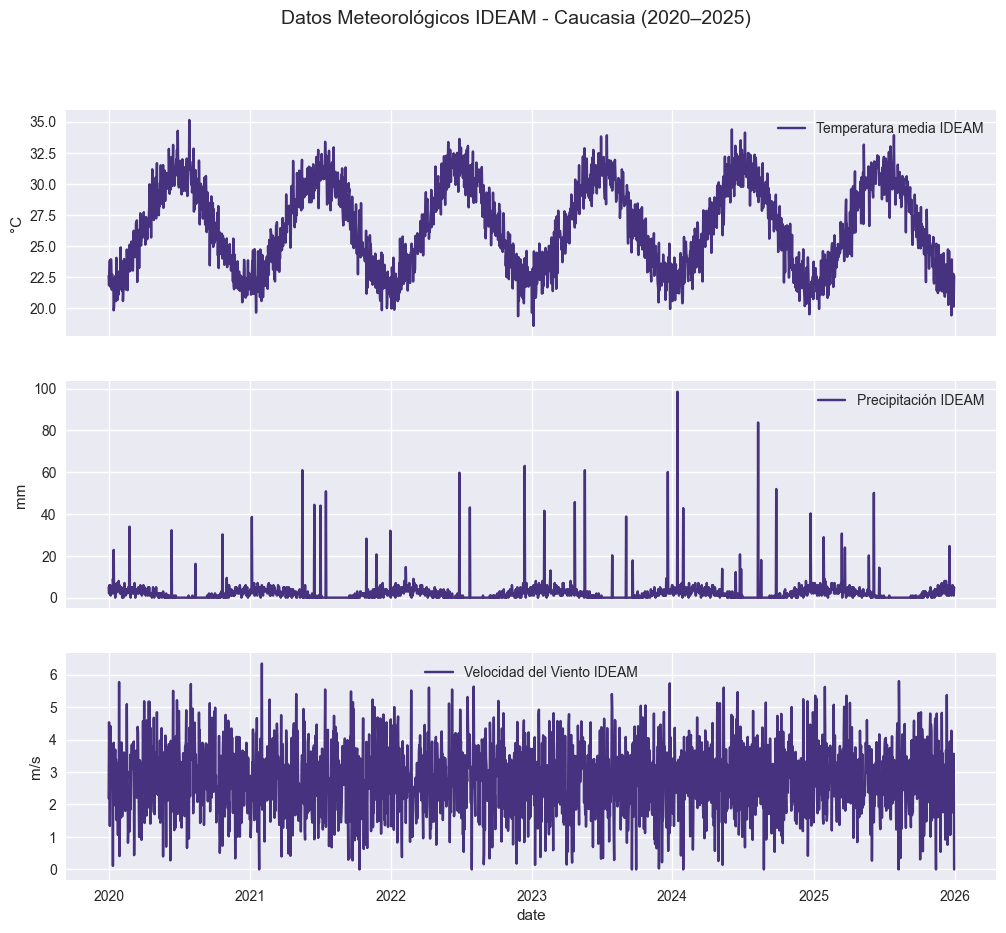

In [12]:

# -------------------------------
# 4. Gráficos meteorológicos
# -------------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=ideam, x="date", y='tmean_C', ax=axes[0],\
    label="Temperatura media IDEAM")
axes[0].set_ylabel("°C")

sns.lineplot(data=ideam, x="date", y='precip_mm', ax=axes[1], \
    label="Precipitación IDEAM")
axes[1].set_ylabel("mm")

sns.lineplot(data=ideam, x="date", y='wind_m_s', ax=axes[2], \
    label="Velocidad del Viento IDEAM")
axes[2].set_ylabel("m/s")

fig.suptitle("Datos Meteorológicos IDEAM - Caucasia (2020–2025)", fontsize=14)
plt.savefig(r"C:\Users\marco\Downloads\meteorologia_ideam_caucasia.png",\
    dpi=300, bbox_inches="tight")
plt.show()


In [ ]:

# -------------------------------
# 5. Gráficos epidemiológicos
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=epi, x="date", y="cases", ax=ax, label="Casos diarios")
sns.lineplot(data=epi, x="date", y="hospitalizations", ax=ax, label="Hospitalizaciones")
ax.set_ylabel("Número de casos")
ax.set_title("Epidemiología - Caucasia (2020–2025)")
plt.legend()
plt.show()

# -------------------------------
# 6. Resúmenes agregados
# -------------------------------
# Resumen semanal
epi_weekly = epi.resample("W", on="date").sum(numeric_only=True)
print("Resumen epidemiológico semanal:")
display(epi_weekly.head())

# Resumen mensual de IDEAM
ideam_monthly = ideam.resample("M", on="date").mean(numeric_only=True)
print("Resumen meteorológico mensual (IDEAM):")
display(ideam_monthly.head())

# Visualización resumen mensual
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=ideam_monthly, x=ideam_monthly.index, y="temperature", ax=ax, label="Temperatura media")
sns.lineplot(data=ideam_monthly, x=ideam_monthly.index, y="humidity", ax=ax, label="Humedad media")
ax.set_ylabel("Valores promedio")
ax.set_title("Resumen mensual Meteorológico IDEAM")
plt.legend()
plt.show()


```

---

📌 **Cómo usarlo en VS Code (Jupyter):**

1. Coloca el script en una celda de tu cuaderno `.ipynb`.
2. Asegúrate de que los `.csv` estén en el mismo directorio del cuaderno (o cambia las rutas en `pd.read_csv`).
3. Ejecuta celda por celda para ver las tablas y gráficos.

---

¿Quieres que te adapte este mismo script para que genere un **dashboard interactivo** con `ipywidgets` (sliders para elegir rango de fechas, variables, etc.)?



---



# 2) Qué se genera (archivos)

Al ejecutar el script que yo corrí aquí, el paquete generado contiene:

* `meteorology_IDEAM_Caucasia_001.csv` — serie diaria 2020-01-01 → 2025-12-31 con tmin, tmean, tmax, rh\_pct, precip\_mm, wind\_m\_s y `station_id`.
* `meteorology_MiraCielo_002.csv` — segunda estación con un hueco declarado (sensor change) en 2021-11-02 → 2021-11-12 (NaNs introducidos intencionalmente).
* `epidemiology_caucasia_municipal.csv` — casos diarios y hospitalizaciones; incluye hueco en 2022-08-10 → 2022-08-17 para emular fallos en reporte.
* `stations_metadata.csv` — metadatos de estaciones (lat/lon/elev/source/notes).
* `inventory.json` — inventario con SHA256 para cada CSV, periodo, frecuencia y metadatos de procedencia.
* `caucasia_synthetic_raw_2020_2025.zip` — ZIP con todos los archivos anteriores.

En el entorno donde ejecuté el script (notebook), el ZIP quedó en:
`/mnt/data/caucasia_synthetic_raw_2020_2025.zip`

Y los archivos CSV en:
`/mnt/data/raw/`

Hashes mostrados (ejemplo generado):

* meteorology\_IDEAM\_Caucasia\_001.csv: `c49261e9...`
* meteorology\_MiraCielo\_002.csv: `316d33b5...`
* epidemiology\_caucasia\_municipal.csv: `97db3db1...`
* stations\_metadata.csv: `d16ce287...`

(En ejecución local tus hashes cambiarán si replicas el proceso con distinta semilla.)

---



# 3) Cómo usarlo en tu pipeline ETL

Recomendaciones rápidas:

* Integra este script como una etapa `01_generate_synthetic.py` dentro de `/data/raw/` para pruebas del pipeline.
* Para pasar a la fase de limpieza (`02_clean.py`) apunta a `raw/*.csv` y usa `inventory.json` para validar integridad (hashes y periodos).
* Mantén la semilla (`np.random.seed(...)`) si quieres reproducibilidad exacta entre ejecuciones.

---



# 4) ¿Quieres que haga algo más ahora?

Puedo, según prefieras:

* Ajustar la generación (más estaciones, variabilidad espacial, diferentes poblaciones municipales).
* Incluir variables adicionales (radiación solar, velocidad del viento horaria, índice de vegetación).
* Entregar el notebook ETL completo (descarga → limpieza → transformaciones → integración) listo para correr con estos archivos sintéticos.
* Generar un conjunto de pruebas de calidad automáticas (checks) que validen rangos, continuidad, y alertas en `inventory.json`.

Dime cuál de estas opciones quieres y lo hago ahora mismo.



## 2) Limpieza de Datos

**Objetivo**: detectar y corregir faltantes, errores de medición y valores atípicos sin sesgar la señal temporal.

**Pasos y técnicas**

1. **Verificación inicial**

   * Comprobar integridad de fechas (continuidad diaria), duplicados, y formatos.
   * Identificar cambios en la estación (cambios de sensor/ubicación) usando metadatos.

2. **Identificación de faltantes y anomalías**

   * Estadísticas por variable: % de datos faltantes por estación/periodo.
   * Visual: heatmap de presencia/ausencia por fecha.
   * Identificar outliers con métodos combinados: IQR por ventana estacional, Z-score por temporada, y técnicas robustas como **Hampel filter** y **Isolation Forest** para outliers multivariados (meteorología + epidemiología).

3. **Manejo de datos faltantes**

   * **Pequeños huecos (1–3 días)**: interpolación temporal (lineal o spline) o **interpolación estacional** (por día del año promedio).
   * **Huecos medianos (4–30 días)**: imputación por **modelo de series temporales** (ej. ETS o Kalman smoothing / state-space), o por regresión con estaciones cercanas (spatial kriging o regresión múltiple).
   * **Huecos largos (>30 días)**: marcar como no imputados si la imputación es arriesgada; usar variables agregadas (semana/mes) donde sea viable.
   * **Epidemiología – casos**: evitar imputaciones automáticas agresivas. Cuando falten reportes, documentar cambios de sistema de reporte; considerar imputación por distribución de Poisson/Gamma condicionada a tendencias de semanas previas y covariables meteorológicas sólo si está justificado.

4. **Corrección de errores de medición**

   * Validar rangos físicos (p. ej. temperatura plausible, humedad 0–100%). Valores fuera de rango → marcar como inválidos.
   * Si hay saltos bruscos coincidentes con cambios de sensor, ajustar series por comparaciones con estaciones vecinas usando regresión para calibrar.

5. **Registro de decisiones**

   * Crear un log de limpieza (tipo) por fecha y registro (qué se imputó, método, justificativo).

---

## 3) Transformación de Datos

**Objetivo**: preparar variables adecuadas para análisis y para ser usadas como exógenas en SARIMAX.

**Transformaciones recomendadas**

1. **Fechas y calendario**

   * Convertir a índice de tiempo (DatetimeIndex) en pandas; crear columnas: `date`, `year`, `month`, `day`, `dow` (día semana), `doy` (día del año), `epiweek` (semana epidemiológica ISO) si usarás análisis semanal.

2. **Variables derivadas meteorológicas**

   * **Medias móviles**: 7, 14, 30 días (ej.: `temp_7d_mean`, `precip_14d_sum`).
   * **Acumulados**: precipitación acumulada 7/14/30 días.
   * **Índices**: *heat index* (temperatura + humedad), *evapotranspiración aproximada* (si tienes radiación o viento), `Tmin`, `Tmax` diarias.
   * **Anomalías estacionales**: valor − media diurna histórica (por día del año), para resaltar episodios anómalos.
   * **Indicadores discretos**: `had_precip` (booleano si lluvia > 0.1 mm).

3. **Variables epidemiológicas**

   * **Counts vs rates**: preferir tasas por 1000 habitantes cuando sea relevante; si solo tienes counts, incluir `population` para convertir.
   * **Transformaciones**: `log(count + 1)` para estabilizar varianza; diferencia (diff) si modelas cambios.
   * **Lags**: crear `cases_lag_1..lag_k` y lags meteorológicos (`precip_lag_0..lag_m`) hasta el máximo plausible (p. ej. 0–28 días) según biología del vector/enfermedad.
   * **Promedios lagged**: media de temperatura lag 7–14 días (para efectos retrasados).

4. **Escalado/normalización**

   * Para selección de covariables y regularización: **standard scaler** (z-score) o **min-max**; mantener copias sin escalar para interpretabilidad de coeficientes.
   * No escalar variables que vayas a usar en transformaciones dirigidas a SARIMAX si quieres interpretar magnitudes directamente; escalar cuando uses algoritmos de selección multivariada o regularizados.

5. **Estacionariedad y transformaciones de Box–Cox**

   * Probar **ADF** para stationarity; si no estacionaria, usar **diferenciación** (d, D) y/o Box–Cox (registrar lambda).

---

## 4) Integración de Datos

**Objetivo**: producir un dataset final con índice temporal consistente y variables debidamente alineadas para SARIMAX (endógena + exógenas).

**Pasos concretos**

1. **Unificar frecuencia**

   * Mantener **diaria**; si algunas series son horarias, agregarlas (media/suma) a diario. Si epidemiología solo está semanal, mantener diaria con NaN diarios y luego agregar (o expandir semanal a diario con la misma tasa — documentar). Para SARIMAX es preferible tener la misma frecuencia en endógena y exógenas.

2. **Alineamiento temporal**

   * **Join** por fecha (left-join usando la serie endógena como referencia).
   * Para datos con frecuencia distinta: `resample('D').sum()` o `.mean()` según contexto. Para pasar de diaria a semanal usar `resample('W-MON')` o `W-SUN` según definición de semana epidemiológica.

3. **Manejo de desfases biológicos**

   * Construir una **matriz de diseño** de exógenas con múltiples lags y agregados (p. ej. `precip_lag_7`, `temp_14d_mean`) para explorar retardos en EDA y en selección de modelo.
   * Procurar no incluir lags redundantes que generen multicolinealidad extrema; usar selección por VIF o PCA cuando sea necesario.

4. **Coherencia y validación**

   * Verificar que después de la integración no hayan saltos no explicados (p. ej. cuando faltó toda una semana en meteorología).
   * Comprobar correlaciones temporales y que las fechas de eventos (picos epidémicos) coincidan con la información de notificación.

5. **Formato de salida**

   * Guardar dataset consolidado en **Parquet** (compacto, mantiene tipos) y en **CSV** para interoperabilidad.
   * Acompañar con `metadata.yml` que describa variables, unidades, método de imputación y versión.

---

## 5) Análisis Exploratorio de Datos (EDA)

**Objetivo**: entender patrones estacionales, tendencias, relaciones y retardos entre meteorología y epidemiología antes de modelar.

**Técnicas y visualizaciones recomendadas**

1. **Series temporales**

   * Gráficas de la serie endógena (casos, hospitalizaciones) superpuestas con principales exógenas (temp, precip) — plot diario y smoothing (LOESS).
   * Gráficas desagregadas por año para visualizar estacionalidad.

2. **Descomposición**

   * `seasonal_decompose` (additive/multiplicative) o STL para separar tendencia, estacionalidad y residuo.

3. **Autocorrelaciones**

   * ACF/PACF de la serie endógena y de los residuos iniciales (para sugerir órdenes ARIMA p,q y diferencias).
   * CCF (cross-correlation function) entre casos y cada meteorológica para detectar retardos con máxima correlación (ej.: precip lag 10).

4. **Correlaciones y lag plots**

   * Heatmap de correlación entre variables y entre lags (matriz corr de `cases` vs `temp_lag_0..28`, etc.).
   * Scatter plots y *lag scatter plots* para patrones no lineales.

5. **Estadísticas descriptivas**

   * Media, mediana, desviación, percentiles, % de ceros (precip), tasas por 1000 hab.
   * Distribuciones (histogramas) y QQ-plots para verificar normalidad (útil para decidir transformaciones).

6. **Identificación de rupturas estructurales**

   * Pruebas de cambio de régimen (CUSUM, Chow test) si fue implementado un cambio en reportes o intervención sanitaria.

7. **Análisis de colinealidad**

   * VIF para exógenas; si VIF alto (>10) considerar combinar variables (PCA) o eliminar.

8. **Pruebas causales exploratorias**

   * **Granger causality tests** para ver si meteorología “granger-predice” casos (no es prueba causal definitiva, pero orienta lags).

9. **Visuales recomendados** (resumen)

   * Time series plots (endógena + exógenas con ejes doble).
   * STL decomposition.
   * ACF/PACF y CCF.
   * Heatmap de correlación lags.
   * Boxplots por mes/estación (para ver estacionalidad).
   * Mapas (si hay variación espacial entre estaciones).

10. **Selección preliminar de covariables**

* Basada en: fuerza de correlación en los lags biológicamente plausibles, significado epidemiológico, VIF y parsimonia.

---

## 6) Documentación y Reproducibilidad

**Objetivo**: asegurar que cualquier investigador pueda reproducir la extracción, limpieza y consolidación, y que el pipeline sea auditable y versionable.

**Prácticas obligatorias**

1. **Control de versiones**

   * Repositorio Git (GitHub/GitLab) con ramas `main`, `dev`.
   * Commits claros; usar *issues* y *pull requests* para cambios mayores.

2. **Pipeline reproducible**

   * Organizar en carpetas: `/data/raw`, `/data/processed`, `/notebooks`, `/src`, `/docs`.
   * Scripts ETL en `/src` (por ejemplo `01_fetch.py`, `02_clean.py`, `03_transform.py`, `04_integrate.py`) ejecutables en orden.
   * Uso de **Makefile** o **Snakemake** para orquestar pasos y dependencias.

3. **Entorno**

   * `environment.yml` (conda) o `requirements.txt` (pip) y `Dockerfile` para reproducibilidad de entorno.
   * Versionar librerías críticas (pandas, statsmodels, scikit-learn).

4. **Notebooks y pruebas**

   * Notebooks Jupyter para EDA y reportes; scripts para ETL.
   * Tests unitarios simples para funciones críticas (por ejemplo: test de integridad de fechas, test de no duplicados), en `tests/`.

5. **Metadatos y registros**

   * `metadata.yml` explicando variables, unidades, origen, método de imputation y cambios de versión de datos.
   * `provenance.log` o `data_catalog.csv` con hashes de archivos originales, fecha extracción, y persona responsable.

6. **Documentos y reportes**

   * Generar informes reproducibles (nbconvert, papermill, or GitHub Actions) que creen reportes PDF/HTML con EDA y resumen de calidad.
   * Mantener un changelog (CHANGELOG.md) para la base de datos y los modelos.

7. **Políticas y ética**

   * Si datos epidemiológicos son sensibles: anonimizar, agregar por fecha/área mínima, revisar permisos y políticas de protección de datos (Ley de Protección de Datos en Colombia).
   * Guardar y documentar consentimiento/uso cuando aplique.

8. **Entrega y preservación**

   * Versión final del dataset (por ejemplo: `caucasia_timeseries_v1.0.parquet`) con DOI si se publica (Zenodo / institutional repo).
   * Backup regular y control de acceso (roles).

---

## Apéndice práctico (resumen técnico y recomendaciones concretas)

* **Frecuencia**: conservar diaria, agregar semanal/mes según necesidad.
* **Periodo de análisis**: objetivo ≥ 10–16 años (2007–2024 recomendado).
* **Imputación preferida**: pequeña—interpolación; mediana—Kalman smoothing o model-based; grande—usar datos de estaciones vecinas o marcar como no confiable.
* **Outliers**: combinar filtros estadísticos (IQR/Hampel) y técnicas de ML (Isolation Forest) para detección; manual review cuando afecte picos epidémicos.
* **Formato de almacenamiento**: Parquet + metadata YAML; raw en CSV/zip.
* **Pipeline**: scripts versionados + Docker + pruebas automatizadas.
* **Validación de modelos**: usar validación temporal (rolling-origin / expanding window) y métricas RMSE/MAE/MAPE; revisar residuos (no autocorrelación, homocedasticidad).
* **Selección exógenas para SARIMAX**: basarse en EDA (CCF + plausibilidad biológica); controlar multicolinealidad; probar modelos con distintos sets de lags y seleccionar por AIC/BIC y performance out-of-sample.

---

## Consejos operativos finales y decisiones prácticas

1. **Empieza por un “proyecto piloto”** con 3–5 años de datos completos para validar pipeline y decisiones de imputación antes de aplicar al archivo histórico completo.
2. **Documenta cada decisión** en el `provenance.log` (p. ej. “imputé 2012-03-05..2012-03-08 precip con spline debido falla de sensor; fuente estación X”).
3. **Mantén comunicación activa con el personal local** (Secretaría de Salud y técnicos IDEAM) para conocer cambios de protocolo y mantenimiento de estaciones.
4. **Automatiza** extracciones periódicas y notificaciones de calidad (p. ej. alerta si % faltantes diario > 5%).

---

Si quieres, te puedo entregar lo siguiente **listo para ejecutar** (elige uno o varios):

* Un **notebook Jupyter** (Python/pandas/statsmodels) con un pipeline ETL mínimo (descarga-sintética → limpieza → transformaciones → dataset final) y ejemplos de EDA y tests ADF/ACF para SARIMAX.
* Plantillas `metadata.yml`, `provenance.log` y `Makefile`/`Dockerfile` para producción.
* Un esquema de **matriz de lags** sugerida (precip/temp/humidity con lags 0–28 y medias móviles 7/14/30) listo para usar.

¿Quieres que te genere el notebook ETL ejemplo y las plantillas comentadas para tu proyecto en Caucasia (lo creo en formato Jupyter listo para ejecutar)? Puedo prepararlo inmediatamente.


# Metodología para tratamiento de los datos en esta investigación 

1. Generacion los datos meteorológicos y epidemiológicos que emulen los de [AMSC](https://www.antioquiamirasucielo.org/): 
2. Generacion los datos meteorológicos y epidemiológicos que emulen los de NASA POWER:   
3. determinar los rezagos de cada variable. Es decir, los $k_{i}$ de cada variable $X_{i}$.
4. Transformar los datos en datos que tienen en cuenta tales rezagos. Es decir, que las variables ya queden de la forma $X_{i, t-k_{i}}$. 